In [1]:
import json
import os
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import yaml
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms, datasets
from torchinfo import summary
from GaborNet.GaborLayer import GaborConv2d

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.g1 = nn.Conv2d(1, 16, kernel_size=(5, 5), stride=1, padding=2)
        self.c1 = nn.Conv2d(16, 32, kernel_size=(5, 5), stride=1, padding=2)
        self.c2 = nn.Conv2d(32, 64, kernel_size=(5, 5), stride=1, padding=2)
        self.fc1 = nn.Linear(64*3*3, 288)
        self.fc2 = nn.Linear(288, 10)

    def forward(self, x):
        x = F.max_pool2d(F.leaky_relu(self.g1(x)), kernel_size=2)
        x = F.max_pool2d(F.leaky_relu(self.c1(x)), kernel_size=2)
        x = F.max_pool2d(F.leaky_relu(self.c2(x)), kernel_size=2)
        x = x.view(x.size(0), -1)
        x = F.leaky_relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)

        return x

In [2]:
class GaborNN(nn.Module):
    def __init__(self):
        super(GaborNN, self).__init__()
        self.g1 = GaborConv2d(1, 16, kernel_size=(5, 5), stride=1, padding=2)
        self.c1 = nn.Conv2d(16, 32, kernel_size=(5, 5), stride=1, padding=2)
        self.c2 = nn.Conv2d(32, 64, kernel_size=(5, 5), stride=1, padding=2)
        self.fc1 = nn.Linear(64*3*3, 288)
        self.fc2 = nn.Linear(288, 10)

    def forward(self, x):
        x = F.max_pool2d(F.leaky_relu(self.g1(x)), kernel_size=2)
        x = F.max_pool2d(F.leaky_relu(self.c1(x)), kernel_size=2)
        x = F.max_pool2d(F.leaky_relu(self.c2(x)), kernel_size=2)
        x = x.view(x.size(0), -1)
        x = F.leaky_relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)

        return x

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize([0.5], [0.5])
])

In [4]:
train_set = datasets.MNIST(root="./MNIST", train=True, transform=transform, download=True,)
test_set = datasets.MNIST(root="./MNIST", train=False, transform=transform)

In [5]:
train = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)
test = DataLoader(test_set, batch_size=64, shuffle=True, num_workers=2)

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
'''
torch.manual_seed(123)
if device =='cuda':
    torch.cuda.manual_seed_all(123) 
'''
print(device)

cpu


In [7]:
net = GaborNN().to(device)
print(net)

GaborNN(
  (g1): GaborConv2d(
    (conv_layer): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
  )
  (c1): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (c2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=576, out_features=288, bias=True)
  (fc2): Linear(in_features=288, out_features=10, bias=True)
)


In [8]:
summary(net, input_size=(64, 1, 28, 28))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Layer (type:depth-idx)                   Output Shape              Param #
GaborNN                                  --                        --
├─GaborConv2d: 1-1                       [64, 16, 28, 28]          --
│    └─Conv2d: 2-1                       [64, 16, 28, 28]          400
├─Conv2d: 1-2                            [64, 32, 14, 14]          12,832
├─Conv2d: 1-3                            [64, 64, 7, 7]            51,264
├─Linear: 1-4                            [64, 288]                 166,176
├─Linear: 1-5                            [64, 10]                  2,890
Total params: 233,562
Trainable params: 233,562
Non-trainable params: 0
Total mult-adds (M): 352.62
Input size (MB): 0.20
Forward/backward pass size (MB): 11.39
Params size (MB): 0.93
Estimated Total Size (MB): 12.53

In [11]:
optimizer = optim.Adam(net.parameters())
criterion = nn.CrossEntropyLoss()

In [9]:
with open("../params.yaml", "r") as stream:
        try:
            params = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
print(params["sanity_check"]["epoch"])

10


In [12]:
one_layer_gnet_acc_train = []
one_layer_gnet_acc_test = []
time_per_image_train = []
time_per_image_test = []

for epoch in range(params["sanity_check"]["epoch"]):

    running_loss = 0.0
    correct = 0
    net.train()
    start = time.perf_counter()
    for inputs, labels in train:
        # get the inputs
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        pred = outputs.max(1, keepdim=True)[1].to("cpu")
        correct += pred.eq(labels.view_as(pred)).sum().item()

        # print statistics
        running_loss += loss.item()
    finish = time.perf_counter()
    time_per_image_train.append((finish - start) / len(train_set))
    print(
        "[%d] train_acc: %.3f train_loss: %.3f"
        % (epoch + 1, correct / len(train_set), running_loss / len(train_set))
    )
    one_layer_gnet_acc_train.append(correct / len(train_set))

    running_loss = 0.0
    correct = 0
    start = time.perf_counter()
    with torch.no_grad():
        net.eval()
        for inputs, labels in test:
            # get the inputs
            inputs, labels = inputs.to(device), labels.to(device)

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            pred = outputs.max(1, keepdim=True)[1].to("cpu")
            correct += pred.eq(labels.view_as(pred)).sum().item()
            running_loss += loss.item()
    finish = time.perf_counter()
    time_per_image_test.append((finish - start) / len(test_set))
    print(
        "[%d] test_acc: %.3f test_loss: %.3f"
        % (epoch + 1, correct / len(test_set), running_loss / len(test_set))
    )
    one_layer_gnet_acc_test.append(correct / len(test_set))

print("Finished Training")


[1] train_acc: 0.897 train_loss: 0.025
[1] test_acc: 0.975 test_loss: 0.023
[2] train_acc: 0.973 train_loss: 0.023
[2] test_acc: 0.983 test_loss: 0.023
[3] train_acc: 0.981 train_loss: 0.023
[3] test_acc: 0.988 test_loss: 0.023
[4] train_acc: 0.984 train_loss: 0.023
[4] test_acc: 0.989 test_loss: 0.023
[5] train_acc: 0.986 train_loss: 0.023
[5] test_acc: 0.987 test_loss: 0.023
[6] train_acc: 0.987 train_loss: 0.023
[6] test_acc: 0.988 test_loss: 0.023
[7] train_acc: 0.989 train_loss: 0.023
[7] test_acc: 0.990 test_loss: 0.023
[8] train_acc: 0.989 train_loss: 0.023
[8] test_acc: 0.989 test_loss: 0.023
[9] train_acc: 0.990 train_loss: 0.023
[9] test_acc: 0.991 test_loss: 0.023
[10] train_acc: 0.991 train_loss: 0.023
[10] test_acc: 0.989 test_loss: 0.023
Finished Training


In [21]:
print("CNN_Accuaracy:", one_layer_gnet_acc_train[-1])
print("time_per_image_train:", sum(time_per_image_train) / len(time_per_image_train) )

CNN_Accuaracy: 0.9766833333333333
time_per_image_train: 0.0022692948925199996


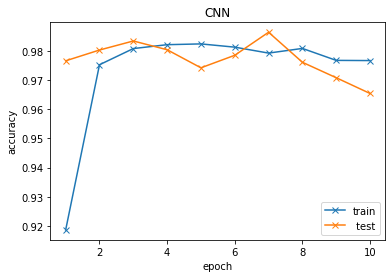

In [23]:
xpt = []
for i in range(params["sanity_check"]["epoch"]):
  i+=1
  xpt.append(i)

plt.title('CNN')
plt.xlabel('epoch')
plt.ylabel('accuracy')
Data_1, = plt.plot(xpt, one_layer_gnet_acc_train, '-x',label ='train')
Data_2, = plt.plot(xpt, one_layer_gnet_acc_test, '-x', label =' test')
plt.legend()
plt.show()

In [13]:
print("GaborNet_Accuaracy:", one_layer_gnet_acc_train[-1])
print("time_per_image_train:", sum(time_per_image_train) / len(time_per_image_train) )

GaborNet_Accuaracy: 0.9905333333333334
time_per_image_train: 0.0007841794706083333


In [ ]:
xpt = []
for i in range(params["sanity_check"]["epoch"]):
  i+=1
  xpt.append(i)

plt.title('GaborNN')
plt.xlabel('epoch')
plt.ylabel('accuracy')
Data_1, = plt.plot(xpt, one_layer_gnet_acc_train, '-x',label ='train')
Data_2, = plt.plot(xpt, one_layer_gnet_acc_test, '-x', label =' test')
plt.legend()
plt.show()